# BBM 409 - Programming Assignment 2

**PART 1:** Binary Classification with SVM (30 points)  
**PART 2:** Multiclass Classification (70 points)


* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

###  Insert personal information (name, surname, student id)

In [ ]:
# Name: Gökdeniz Surname: Kuruca ID: 2230356129

## Import Required Libraries

In [3]:
## Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from ucimlrepo import fetch_ucirepo

import warnings
warnings.filterwarnings('ignore')

---
# PART 1: BINARY CLASSIFICATION WITH SVM (30 POINTS)
---

## Load the Sonar Dataset from UCI Repository

In [4]:
# Load data
print("Loading Sonar dataset...")
sonar = fetch_ucirepo(id=151)
X_sonar = sonar.data.features
y_sonar = sonar.data.targets

Loading Sonar dataset...


## Encode the Target Labels using LabelEncoder()

In [5]:
# Encode target labels
encoder = LabelEncoder()

y_sonar["class"] = encoder.fit_transform(y_sonar)

## Split the Data into 80% Training and 20% Testing Sets

In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_sonar,y_sonar,random_state=42)

---
## 1.1. Linear Kernel SVM without Hyperparameter Tuning (5 points)
---

## Create a Pipeline with StandardScaler and Linear SVM

In [7]:
# Create pipeline for clasical SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='linear'))
])

## Train the Linear SVM Model

In [8]:
# Train
pipeline_svm.fit(X_train, y_train)

,steps,"[('scaler', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'


## Predict on the Test Set and Calculate Accuracies and Print it

In [9]:
# Best model predictions
y_pred = pipeline_svm.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy of Best Model: {test_accuracy:.4f}")

Test Accuracy of Best Model: 0.8269


## Display Classification Report for Linear SVM

In [10]:
# Classification report
svm_report = classification_report(y_test, y_pred)
print(svm_report)

              precision    recall  f1-score   support

           0       0.92      0.77      0.84        30
           1       0.74      0.91      0.82        22

    accuracy                           0.83        52
   macro avg       0.83      0.84      0.83        52
weighted avg       0.84      0.83      0.83        52



## Display Confusion Matrix for Linear SVM

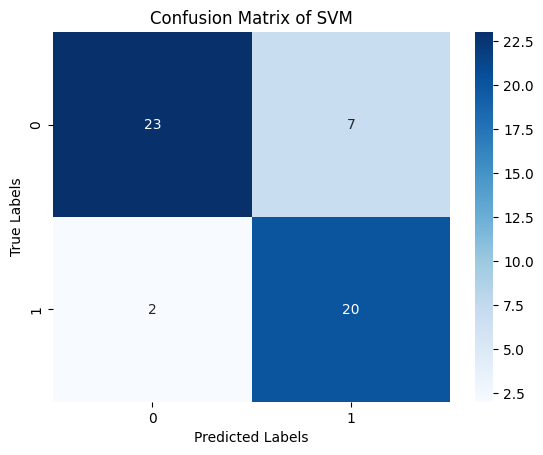

In [11]:
# Confusion matrix
svm_confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(svm_confusion_matrix, annot = True, cmap = "Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of SVM")
plt.show()

---
## 1.2. SVM with GridSearchCV and 5-Fold Cross-Validation (15 points)
---

## Create a Pipeline for GridSearchCV

## Define the Parameter Grid for Different Kernels

In [12]:
# Parameters for Grid Search
parameters = [
  {
    "svc__kernel": ["linear"],
    "svc__C": [0.1,1,10,100]
  },
  {
    "svc__kernel":["rbf"],
    "svc__C": [0.1,1,10,100],
    "svc__gamma":["scale","auto",0.001,0.01]
  },
  {
    "svc__kernel":["poly"],
    "svc__C":[0.1,1,10,100],
    "svc__gamma":["scale","auto",0.001,0.01],
    "svc__degree":[2,3,4]
  }
]

## Create Stratified 5-Fold Cross-Validation

In [13]:
# 5-Fold Cross Validation
skf = StratifiedKFold(n_splits = 5)
clf = GridSearchCV(pipeline_svm,
                   parameters,
                   cv = skf)

## Initialize and Run GridSearchCV on Training Data

In [14]:
# Train model
clf.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid=[{'svc__C': [0.1, 1, 10, 100],
                          'svc__kernel': ['linear']},
                         {'svc__C': [0.1, 1, 10, 100],
                          'svc__gamma': ['scale', 'auto', 0.001, 0.01],
                          'svc__kernel': ['rbf']},
                         {'svc__C': [0.1, 1, 10, 100], 'svc__degree': [2, 3, 4],
                          'svc__gamma': ['scale', 'auto', 0.001, 0.01],
                          'svc__kernel': ['poly']}])

## Display Best Parameters and Cross-Validation Score

In [15]:
# Best model parameters
results = pd.DataFrame(clf.cv_results_)

best_row = results.loc[results["mean_test_score"].idxmax()]

print(f"Best Score: {best_row['mean_test_score']:.4f}")
print("Best Params:", best_row["params"])

Best Score: 0.8268
Best Params: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


## Evaluate the Best Model on the Test Set

In [16]:
# Best model predictions
y_pred = clf.best_estimator_.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy of Best Model: {test_accuracy:.4f}")

Test Accuracy of Best Model: 0.9423


## Display Top 5 Parameter Combinations

In [17]:
# Top 5 model parameters
top5 = results.sort_values("mean_test_score", ascending=False)[["mean_test_score", "params"]].head(5)

for idx, row in top5.iterrows():
    print(f"{idx}. Mean Test Score: {row['mean_test_score']:.4f}")
    print(f"   Params: {row['params']}\n")

12. Mean Test Score: 0.8268
   Params: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

13. Mean Test Score: 0.8268
   Params: {'svc__C': 10, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}

17. Mean Test Score: 0.8268
   Params: {'svc__C': 100, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}

16. Mean Test Score: 0.8268
   Params: {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

15. Mean Test Score: 0.8266
   Params: {'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}



## Display Classification Report for Tuned SVM

In [18]:
# Classifiaciton report
report_tuned_svm = classification_report(y_test, y_pred)
print(report_tuned_svm)

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        30
           1       0.91      0.95      0.93        22

    accuracy                           0.94        52
   macro avg       0.94      0.94      0.94        52
weighted avg       0.94      0.94      0.94        52



## Display Confusion Matrix for Tuned SVM

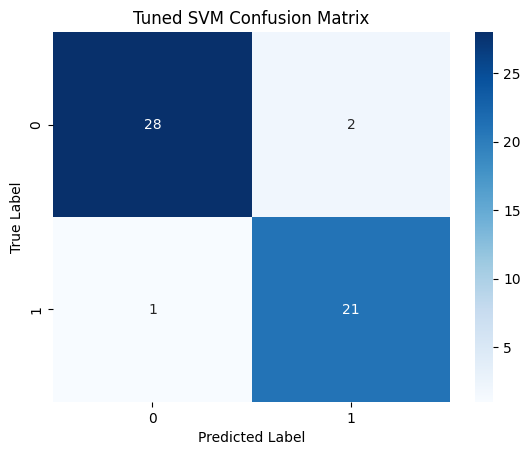

In [19]:
# Confusion matrix
tuned_svm_confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(tuned_svm_confusion_matrix, annot = True, cmap = "Blues")
plt.title("Tuned SVM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Compare Linear SVM vs Tuned SVM Results. Compare experimental results. Explain the performance impact of linear and nonlinear kernels. Why is kernel trick important? Also explain why using k-fold cross validation is more advantageous than train-test split. (10 points)

Linear SVM achieved an accuracy of 0.83. For class 0, precision was 0.92, recall 0.77, and F1 score 0.84. On the other hand class 1 precision was 0.74, recall 0.91, and F1 score 0.82. These results indicate that the data may not be linearly separable. While the data performed well in linearly separable parts, the nonlinearly separable features also performed poorly.

Transitioning to a Tuned SVM with an RBF kernel resulted in a significant boost in classification accuracy. Tuned SVM using an RBF kernel improved performance to an accuracy of 0.94. Class 0 achieved 0.97 precision, 0.93 recall, and 0.95 F1 score. On the other side class 1 achieved 0.91 precision, 0.95 recall, and 0.93 F1 score. This demonstrates a more balanced performance across classes, highlighting the benefit of nonlinear kernels. These results, when combined with the linear kernel results, strengthen the thesis that the data are linearly separated.

When linear kernels are compared with nonlinear kernels, significant differences are evident. Linear kernels assume that the data is linearly separable and are computationally efficient. Furthermore, they can't capture nonlinear decision boundaries. Nonlinear kernels, project the data into a higher dimensional space, enabling the SVM to find linear separation in that space. This capability improves performance on datasets with nonlinear patterns.

The most important feature of the kernel trick is that it allows implicit mapping to high-dimensional feature spaces without explicitly computing the transformation. By calculating inner products in the transformed space through a kernel function, it efficiently handles nonlinear separations without high computational cost.

Using k-fold cross-validation instead of a single train test split provides more reliable performance estimates. In k-fold, the dataset is divided into k subsets, each serving as a test set once while the remaining k-1 subsets are used for training. This reduces variance and ensures the evaluation is not dependent on a single random split. Single train test splits can lead to biased results, especially on small datasets like this experiment.

Hyperparameter optimization revealed several configurations that maximized model performance. The top hyperparameters identified for the RBF SVM include C values of 10 and 100, with gamma settings scale, auto, and 0.01. At the end of the experiment, it was observed that more than one parameter pair achieved the best result. These combinations achieved mean test scores up to 0.8268. Proper tuning of C and gamma is essential to balance underfitting and overfitting and achieve high and stable accuracy.

---
# PART 2: MULTICLASS CLASSIFICATION (70 POINTS)
---

## Load the Dry Beans Dataset from UCI Repository

In [20]:
# Load data
print("Loading Dry Beans dataset...")
dry_bean = fetch_ucirepo(id=602)
X_beans = dry_bean.data.features
y_beans = dry_bean.data.targets

Loading Dry Beans dataset...


## Encode the Target Labels using LabelEncoder

In [21]:
# Encode target labels
encoder = LabelEncoder()
y_beans["Class"] = encoder.fit_transform(y_beans)

## Split the Data into 80% Training and 20% Testing Sets

In [22]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_beans, y_beans, random_state=42)

## Scale the Features using StandardScaler

In [23]:
# Scale features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

---
## 2.1. Multinomial Logistic Regression (20 points)
---

## Define the Multinomial Logistic Regression Class

In [24]:
class MultinomialLogisticRegression():
  """
  Multinomial Logistic Regression classifier using softmax and gradient descent.

  Parameters
    lr (float): Learning rate for gradient updates (default: 0.1)
    epoch (int): Number of training iterations (default: 10)
    reg_lambda (float): Regularization strength (default: 0.0)

  Attributes
    weight (np.ndarray): Weight matrix of shape (n_features, n_classes)
    bias (np.ndarray): Bias vector of length n_classes

  Methods
    fit(X, y): Train the model using full-batch gradient descent.
    predict(X): Predict class index for each sample.
    predict_proba(X): Compute softmax probability distribution for each sample.
    score(X, y): Compute model accuracy on given dataset.
    get_params(): Return model parameters in dictionary format.
    set_params(**params): Update model hyperparameters dynamically.
  """
  def __init__(self,lr=0.1,epoch=10,reg_lambda=0.0):
    self.lr = lr
    self.epoch = epoch
    self.reg_lambda = reg_lambda
    self.weight = None
    self.bias = None

  def _softmax(self, X):
    """
    Compute softmax probability distribution for given input.

    Parameters
      X (np.ndarray): Input feature matrix of shape (n_samples, n_features)

    Returns
      np.ndarray: Probability matrix of shape (n_samples, n_classes)
    """
    z = np.dot(X,self.weight) + self.bias
    z = z - np.max(z,axis=1,keepdims=True) # Float overflow preventer
    exp = np.exp(z)
    total = np.sum(exp,axis=1,keepdims=True)
    return exp/total

  def _cross_entropy(self,labels,probas):
    """
    Compute cross-entropy loss with optional regularization.

    Parameters
      labels (np.ndarray): One-hot encoded true labels
      probas (np.ndarray): Predicted class probabilities

    Returns
      float: Computed loss value
    """
    loss = -np.mean(np.sum(labels * np.log(probas+1e-15), axis=1))
    loss += (self.reg_lambda/2) * np.sum(self.weight**2) # Regularization
    return loss

  def fit(self,X,y):
    """
    Train the model on training dataset using gradient descent.

    Parameters
      X (np.ndarray): Training features of shape (n_samples, n_features)
      y (array-like): Class labels of shape (n_samples,)
    """
    y = self.int_array_check(y)

    n_sample, n_features = X.shape
    n_classes = len(np.unique(y))
    self.weight = np.zeros((n_features, n_classes))
    self.bias = np.zeros(n_classes)

    # Start epochs
    for epoch in range(self.epoch):
      probas = self.predict_proba(X) # Find probalities
      y_onehot = np.zeros((n_sample,n_classes)) # One hot encoding
      y_onehot[np.arange(n_sample),y] = 1

      # Calculate gradients
      grad_w = np.dot(np.transpose(X), (probas-y_onehot))/n_sample
      grad_b = np.mean(probas-y_onehot, axis=0)

      # Update rule
      self.weight -= self.lr * (grad_w + self.reg_lambda * self.weight)
      self.bias -= self.lr * grad_b

  def predict_proba(self,X):
    """
    Return softmax probabilities for each sample.

    Parameters
      X (np.ndarray): Input samples

    Returns
      np.ndarray: Probability matrix
    """
    return self._softmax(X)

  def predict(self,X):
    """
    Predict class labels.

    Parameters
      X (np.ndarray): Input samples

    Returns
      np.ndarray: Predicted class indices
    """
    probas = self.predict_proba(X)
    return np.argmax(probas, axis=1)

  def score(self,X,y):
    """
    Compute accuracy of model.

    Parameters
      X (np.ndarray): Test features
      y (array-like): True labels

    Returns
      float: Accuracy value between 0 and 1
    """
    y = self.int_array_check(y)
    y_pred = self.predict(X)
    return len(np.where(y_pred == y)[0]) / len(y)

  def get_params(self, deep=True):
    """
    Return model hyperparameters as a dictionary.

    Returns:
      dict: Model parameters
    """
    return {"lr": self.lr, "epoch": self.epoch, "reg_lambda": self.reg_lambda}

  def set_params(self,**params):
    """
    Update model hyperparameters dynamically.

    Parameters
      params (dict): Mapping of hyperparameter names and values

    Returns:
      self
    """
    for key, value in params.items():
        setattr(self, key, value)
    return self

  def int_array_check(self, y):
    """
    Ensure labels are converted to a flat integer numpy array.

    Parameters
      y (array-like): Raw labels

    Returns
      np.ndarray: Clean integer label array
    """
    if not isinstance(y, np.ndarray):
        y = y.values
    if y.ndim > 1:
      y = y.flatten()
    y = y.astype(int)

    return y

## Define Hyperparameter Grid for Multinomial Logistic Regression

In [25]:
# Parameters for Grid Search
parameters = {
  "lr": [0.01, 0.05, 0.1],
  "epoch": [200, 300, 500],
  "reg_lambda": [0.0, 0.01, 0.1]
}

## Run GridSearchCV for Multinomial Logistic Regression

In [26]:
# CV and train model
model = MultinomialLogisticRegression()

skf = StratifiedKFold(n_splits = 5)
clf = GridSearchCV(model,
                   parameters,
                   cv = skf)

clf.fit(X_train_scaled,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=<__main__.MultinomialLogisticRegression object at 0x7d99499c4050>,
             param_grid={'epoch': [200, 300, 500], 'lr': [0.01, 0.05, 0.1],
                         'reg_lambda': [0.0, 0.01, 0.1]})

## Evaluate Multinomial Logistic Regression on Test Set

In [27]:
# Best model predictions
y_pred = clf.best_estimator_.predict(X_test_scaled)
test_accuracy = clf.best_estimator_.score(X_test_scaled, y_test)

print(f"Test Accuracy of Best Model: {test_accuracy:.4f}")

Test Accuracy of Best Model: 0.9183


In [28]:
# Best model parameters
results = pd.DataFrame(clf.cv_results_)

best_row = results.loc[results["mean_test_score"].idxmax()]

print(f"Best Score: {best_row['mean_test_score']:.4f}")
print("Best Params:", best_row["params"])

Best Score: 0.9155
Best Params: {'epoch': 500, 'lr': 0.1, 'reg_lambda': 0.0}


In [29]:
# Top5 model parameters
top5 = results.sort_values("mean_test_score", ascending=False)[["mean_test_score", "params"]].head(5)

for idx, row in top5.iterrows():
    print(f"{idx}. Mean Test Score: {row['mean_test_score']:.4f}")
    print(f"Params: {row['params']}\n")

24. Mean Test Score: 0.9155
Params: {'epoch': 500, 'lr': 0.1, 'reg_lambda': 0.0}

25. Mean Test Score: 0.9148
Params: {'epoch': 500, 'lr': 0.1, 'reg_lambda': 0.01}

15. Mean Test Score: 0.9135
Params: {'epoch': 300, 'lr': 0.1, 'reg_lambda': 0.0}

16. Mean Test Score: 0.9123
Params: {'epoch': 300, 'lr': 0.1, 'reg_lambda': 0.01}

21. Mean Test Score: 0.9110
Params: {'epoch': 500, 'lr': 0.05, 'reg_lambda': 0.0}



## Display Classification Report for Multinomial Logistic Regression

In [30]:
# Classification report
logistic_report = classification_report(y_test,y_pred)
print(logistic_report)

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       344
           1       0.99      1.00      1.00       142
           2       0.92      0.95      0.94       402
           3       0.90      0.91      0.91       851
           4       0.95      0.96      0.96       486
           5       0.93      0.94      0.93       513
           6       0.87      0.86      0.86       665

    accuracy                           0.92      3403
   macro avg       0.93      0.93      0.93      3403
weighted avg       0.92      0.92      0.92      3403



## Display Confusion Matrix for Multinomial Logistic Regression

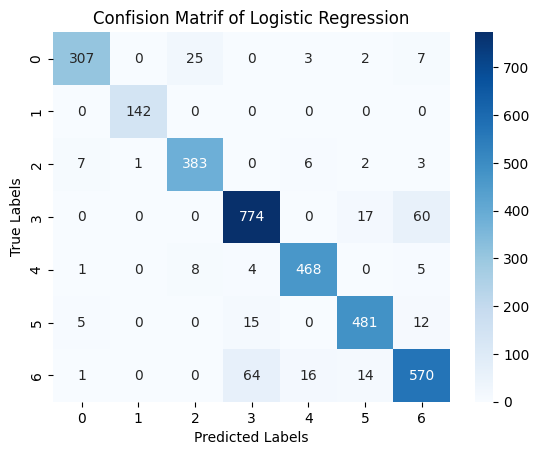

In [31]:
# Confusion matrix
logistic_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(logistic_matrix, annot=True, fmt = "d", cmap="Blues")
plt.title("Confision Matrif of Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

---
## 2.2. Decision Tree (20 points)
---

###  Define the Decision Tree model. Use GridSearchCV to find the best hyperparameters. Perform multiclass classification on the Dry Beans dataset. Print best hyperparameters, classification report and confusion matrix. (15 points)

## Define Hyperparameter Grid for Decision Tree

In [32]:
# Parameters for Grid Search
parameters = {
  "max_depth":[10,15,20,None],
  "min_samples_split":[2,5,10],
  "min_samples_leaf":[1,2,4],
  "criterion":["gini","entropy"]
}

## Run GridSearchCV for Decision Tree

In [33]:
# CV and model train
skf = StratifiedKFold(n_splits = 5)

model = DecisionTreeClassifier()

clf = GridSearchCV(model,parameters,cv = skf)
clf.fit(X_train_scaled,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

## Display Classification Report for Decision Tree

In [34]:
# Best model predictions
y_pred = clf.best_estimator_.predict(X_test_scaled)
test_accuracy = clf.best_estimator_.score(X_test_scaled, y_test)

print(f"Test Accuracy of Best Model: {test_accuracy:.4f}")

Test Accuracy of Best Model: 0.9089


In [35]:
# Best model parameters
results = pd.DataFrame(clf.cv_results_)

best_row = results.loc[results["mean_test_score"].idxmax()]

print(f"Best Score: {best_row['mean_test_score']:.4f}")
print("Best Params:", best_row["params"])

Best Score: 0.9058
Best Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [36]:
# Top5 model parameters
top5 = results.sort_values("mean_test_score", ascending=False)[["mean_test_score", "params"]].head(5)

for idx, row in top5.iterrows():
    print(f"{idx}. Mean Test Score: {row['mean_test_score']:.4f}")
    print(f"Params: {row['params']}\n")

8. Mean Test Score: 0.9058
Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}

7. Mean Test Score: 0.9051
Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}

42. Mean Test Score: 0.9049
Params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}

6. Mean Test Score: 0.9045
Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}

44. Mean Test Score: 0.9045
Params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}



In [37]:
# Classification report
tree_report = classification_report(y_test,y_pred)
print(tree_report)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       344
           1       1.00      1.00      1.00       142
           2       0.90      0.92      0.91       402
           3       0.89      0.91      0.90       851
           4       0.96      0.95      0.96       486
           5       0.96      0.92      0.94       513
           6       0.85      0.86      0.86       665

    accuracy                           0.91      3403
   macro avg       0.92      0.92      0.92      3403
weighted avg       0.91      0.91      0.91      3403



## Display Confusion Matrix for Decision Tree

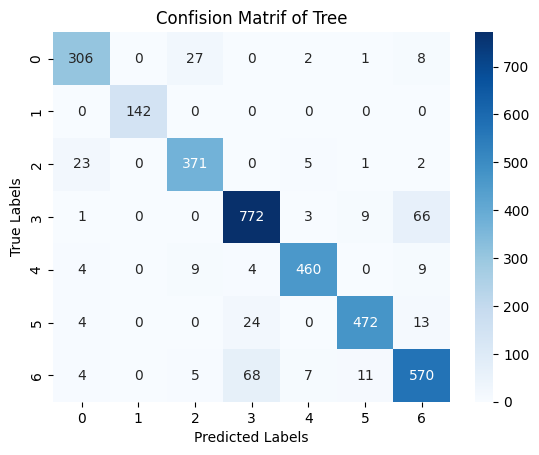

In [38]:
# Confusion matrix
tree_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(tree_matrix, annot=True, fmt = "d", cmap="Blues")
plt.title("Confision Matrif of Tree")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###  Describe how a decision tree builds its decision structure. (5 points)

A decision tree builds its decision structure by recursively partitioning the dataset based on feature values in order to best separate the classes. The process starts at root, where algorithm evaluates all features and potential split points to choose one that maximizes a given splitting criterion. Citerion can be gini or entropy. Gini measures the impurity of a node, while entropy measures the information gain.

Once the root split is selected, the tree continues with recursive splitting. Each resulting node is evaluated for all possible feature splits, and the split that best separates the samples is chosen. This process continues until stopping conditions are met.

The stopping conditions are controlled by hyperparameters. In our example, we have seven classes and the following parameters:

- max_depth: [10, 15, 20, None] — the maximum depth the tree can grow. Limiting depth prevents overfitting.
- min_samples_split: [2, 5, 10] — the minimum number of samples required to split a node. Prevents splits that are too small.
- min_samples_leaf: [1, 2, 4] — the minimum number of samples that a leaf node must contain. Ensures that leaves have enough data.
- criterion: ["gini", "entropy"] — the function used to measure the quality of a split.

When a node meets the stopping conditions, it becomes a leaf node. The predicted class of the leaf is determined by the majority class among the samples in that node. For our dataset with seven classes, the class with the highest count in a leaf is assigned as the prediction. Also hyperparameter tuning helps balance overfitting and underfitting. For example, a tree with max_depth=None might overfit by capturing noise, while a high min_samples_leaf might underfit by oversimplifying the splits. Proper selection of these parameters ensures the tree generalizes well to unseen data.


---
## 2.3. XGBoost (20 points)
---

###  Define the XGBoost model. Use GridSearchCV to find the best hyperparameters. Perform multiclass classification on the Dry Beans dataset. Print best hyperparameters, classification report and confusion matrix(10 points)

## Define Hyperparameter Grid for XGBoost

In [39]:
# Parameters for XGBoost
parameters = {
    "max_depth":[3,5,7,10],
    "learning_rate":[0.01,0.1,0.3],
    "n_estimators":[100,200,300],
    "subsample":[0.8,1.0],
    "colsample_bytree":[0.8,1.0]
}

## Run GridSearchCV for XGBoost

In [40]:
# CV and model train
skf = StratifiedKFold(n_splits = 5)

model = XGBClassifier()

clf = GridSearchCV(model,parameters,cv=skf)
clf.fit(X_train_scaled,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_po...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]})

## Evaluate XGBoost on Test Set

In [41]:
# Best model predictions
y_pred = clf.best_estimator_.predict(X_test_scaled)
test_accuracy = clf.best_estimator_.score(X_test_scaled, y_test)

print(f"Test Accuracy of Best Model: {test_accuracy:.4f}")

Test Accuracy of Best Model: 0.9274


In [42]:
# Best model parameters
results = pd.DataFrame(clf.cv_results_)

best_row = results.loc[results["mean_test_score"].idxmax()]

print(f"Best Score: {best_row['mean_test_score']:.4f}")
print("Best Params:", best_row["params"])

Best Score: 0.9289
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


In [43]:
# Top5 model parameters
top5 = results.sort_values("mean_test_score", ascending=False)[["mean_test_score", "params"]].head(5)

for idx, row in top5.iterrows():
    print(f"{idx}. Mean Test Score: {row['mean_test_score']:.4f}")
    print(f"Params: {row['params']}\n")

108. Mean Test Score: 0.9289
Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}

98. Mean Test Score: 0.9282
Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

114. Mean Test Score: 0.9281
Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}

36. Mean Test Score: 0.9281
Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}

102. Mean Test Score: 0.9281
Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}



## Display Classification Report for XGBoost

In [44]:
# Classification report
xgboost_report = classification_report(y_test,y_pred)
print(xgboost_report)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       344
           1       1.00      1.00      1.00       142
           2       0.94      0.95      0.94       402
           3       0.91      0.92      0.91       851
           4       0.97      0.96      0.97       486
           5       0.95      0.94      0.94       513
           6       0.88      0.88      0.88       665

    accuracy                           0.93      3403
   macro avg       0.94      0.94      0.94      3403
weighted avg       0.93      0.93      0.93      3403



## Display Confusion Matrix for XGBoost

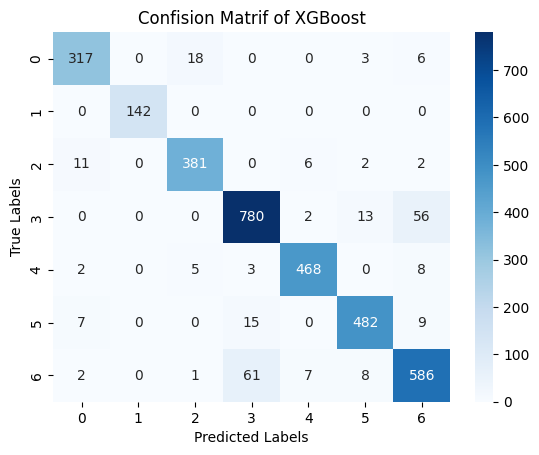

In [45]:
# Confusion matrix
xgboost_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(xgboost_matrix, annot=True, fmt = "d", cmap="Blues")
plt.title("Confision Matrif of XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### What are the revolutionary features of XGBoost compared to other tree-based models? (10 points)

Single Decision Trees serve as the fundamental unit of interpretability, creating decision boundaries through recursive binary splitting based on impurity metrics like Gini or Entropy. While highly intuitive, they suffer from high variance and instability; minor changes in data can lead to drastically different structures, often resulting in severe overfitting. Random Forest addresses this instability by aggregating multiple uncorrelated trees, effectively reducing variance. However, while Random Forest improves generalization, it treats trees independently and fails to utilize gradient information to iteratively correct model errors.

Traditional Gradient Boosting Machines shift the focus from variance reduction to bias reduction by building trees sequentially, where each new tree corrects the residuals of its predecessor. While this minimizes bias, standard GBMs rely solely on first order derivatives for optimization and lack intrinsic regularization mechanisms. This often leads to uncontrolled model complexity and slow convergence on high dimensional data, indicating that first order optimization is insufficient for capturing complex error landscapes.

In contrast, XGBoost revolutionizes this hierarchy by integrating a second order optimization framework that transcends the limitations of its predecessors. Unlike standard GBMs that approximate the loss function using only the gradient, XGBoost utilizes the Second Order Taylor Expansion, incorporating both the gradient and the Hessian. This allows the model to understand the curvature of the loss function, leading to a faster and more precise descent path.

The Taylor Series Approximation of the objective function optimized by XGBoost at each step is expressed as:

$$
Obj^{(t)} \approx \sum_{i=1}^{n} \left[ g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i) \right] + \Omega(f_t)
$$

Here, $g_i$ represents the first derivative, $h_i$ represents the second derivative, and $\Omega$ denotes the regularization term.

Furthermore, XGBoost addresses the overfitting prone nature of Single Trees and standard GBMs by embedding L1 and L2 regularization directly into the objective function. From a computational perspective, it overcomes the sequential bottleneck of boosting through block based parallelization. By employing sparsity aware split finding and cache aware access, XGBoost handles missing data and large scale matrix operations with an efficiency that neither Decision Trees nor standard ensembles can match.

**References**

* Breiman, L. (2001). Random forests. *Machine Learning*, 45(1), 5–32. [https://doi.org/10.1023/A:1010933404324](https://doi.org/10.1023/A:1010933404324)
* Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system. *Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining*, 785–794. [https://doi.org/10.1145/2939672.2939785](https://doi.org/10.1145/2939672.2939785)

###  Compare the classification results of your Multinomial Logistic Regression, Decision Tree, and XGBoost models on the Dry Beans dataset. Discuss the comparison in terms of overall model performance, risk of overfitting, model complexity and the scenarios in which each model is most effective. (10 points)

Upon detailed examination of the performance metrics for Multinomial Logistic Regression, Decision Tree, and XGBoost models, a clear hierarchy emerges between model complexity and predictive success. XGBoost stands out as statistically the most reliable and successful model, achieving both a test accuracy of 0.93 and a 5 fold cross validation score of 0.9289. Logistic Regression follows very closely with an accuracy of 0.92, while the Decision Tree ranks third with an accuracy of 0.91. In the class based performance analysis, the fact that all models achieved an F1 score of 1.00 for Class 1 proves that the morphological features of this bean type are perfectly linearly separable from others. However, the true capabilities of the models were tested on Class 6, which possesses the most complex structure in the dataset. While MLR and Decision Tree plateaued at an F1 score of 0.86 for this class, XGBoost reaching 0.88 marks a critical distinction. This 2% difference symbolizes the distinct advantage of ensemble learning methods over single models in correctly classifying samples that are very close to each other or overlapping in the feature space.

Regarding overfitting control and generalization capabilities, it is observed that all three models achieved high success using strategies best suited to their respective structures. Although XGBoost has the most complex architecture, it struck an excellent balance through the optimization provided by the subsample: 0.8 and max_depth: 7 parameters. These settings allowed the model to capture the finest details in the dataset while ensuring stability, resulting in a superior generalization performance that topped both test and cross validation scores. The Logistic Regression model achieving a high success rate of 92% with the reg_lambda: 0.0 parameter meaning without the need for an additional penalty term proves how strong the model's ability to fit the data is. This is a positive sign indicating that the signals in the dataset are highly favorable for this model. However, the absence of any protective regularization to suppress model weights suggests that the model is theoretically more vulnerable to data shifts and open to variance risk. Therefore, the model's generalizability should be further verified using more test data. The Decision Tree model also followed a successful generalization strategy thanks to the max_depth: 10 and min_samples_leaf: 4 parameters. This configuration prevented the model from getting lost in unnecessary details, allowing it to learn the essence of the data, and its success of over 91% demonstrates that the applied pruning strategy kept the model at a high predictive power.

Evaluating the results from the perspective of model complexity and architectural approach, the fact that a simple model drawing linear decision boundaries like Logistic Regression performed almost on par with a highly complex model like XGBoost indicates that the attributes in the Dry Beans dataset are largely linearly separable. On the other hand, the Decision Tree partitions the space by making orthogonal splits with a max_depth: 10. This method proved insufficient in cases requiring curved boundaries, such as in Class 6. XGBoost, utilizing the n_estimators: 100 parameter, built 100 decision trees sequentially, with each new tree correcting the errors of the previous ones. This Boosting mechanism raised the model's overall success by capturing the nonlinear, complex patterns in that final 1% segment that Logistic Regression could not resolve.

Regarding model selection strategy if project constraints include low processing power, minimum memory usage, and inference speed in the order of milliseconds, Logistic Regression is the most rational choice with its 92% success rate and simple structure. If the decisions made by the model need to be understood by agricultural experts or users through clear rules like "If Area is greater than X, then it is a Class Y", the Decision Tree should be used, accepting the 91% success rate. However, in scenarios where the goal is to minimize the margin of error, such as precision agriculture applications or competitive data science projects, XGBoost is undisputedly the correct choice, justifying the computational cost with its success in distinguishing particularly difficult classes.